In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KernelDensity

# Importing Data

In [2]:
data = pd.read_csv('Dubai Residential Formatted.csv')

In [3]:
metro_data = pd.read_csv('metro_stations.csv')

In [4]:
mall_data = pd.read_csv('mall_data.csv')

In [5]:
data["Nearest Mall"].value_counts()

Nearest Mall
Dubai Mall              10200
Marina Mall              8789
Mall of the Emirates     5918
City Centre Mirdif       3483
Ibn-e-Battuta Mall       1194
Name: count, dtype: int64

# Data Cleaning & Preprocessing


In [6]:
# Dataset contains outdated & incorrect nearest metro stations & malls
# Find nearest stations based on real station & mall locations to the euclidean distance to each location
def find_nearest(property_lat, property_lon, nearby_file):
    property_point = (property_lat, property_lon)

    nearby_file["dist"] = nearby_file.apply(lambda row: distance.euclidean((row["latitude"], row["longitude"]), property_point), axis=1)

    # Find the row with the minimum distance
    nearest_place_row = nearby_file.loc[nearby_file["dist"].idxmin()]

    return nearest_place_row["name"] 

# Apply function to Nearest Metro & Mall Features
data['Nearest Metro'] = data.apply(
    lambda row: find_nearest(row['Latitude_Project'], row['Longitude_Project'], metro_data), axis=1
)

data['Nearest Mall'] = data.apply(
    lambda row: find_nearest(row['Latitude_Project'], row['Longitude_Project'], mall_data), axis=1
)

print("Updated 'Nearest Metro' & 'Nearest Mall' columns based on geographical distance")
print(data[['Latitude_Project', 'Longitude_Project', 'Nearest Metro', 'Nearest Mall']].head())

Updated 'Nearest Metro' & 'Nearest Mall' columns based on geographical distance
   Latitude_Project  Longitude_Project                        Nearest Metro  \
0          25.11072           55.38869                  Creek Metro Station   
1          24.99426           55.16346                 Danube Metro Station   
2          25.07052           55.14381  Jumeirah Lakes Towers Metro Station   
3          25.11000           55.20418   Mall of the Emirates Metro Station   
4          25.11000           55.20418   Mall of the Emirates Metro Station   

           Nearest Mall  
0     Dubai Outlet Mall  
1      Ibn Battuta Mall  
2     Dubai Marina Mall  
3  Mall of the Emirates  
4  Mall of the Emirates  


In [7]:
import pandas as pd
import numpy as np

# Convert to string and replace all invalid values with '0'
data['Parking'] = data['Parking'].astype(str)
data['Parking'] = data['Parking'].replace({'': '0', 'nan': '0', 'N/A': '0', '-1': '0', ' ': '0'})

def count_parking_spots(value):
    value = str(value)
    if value.strip() == '0':
        return 0
    if ',' in value:
        return len(value.split(','))
    return 1

data['Parking'] = data['Parking'].apply(count_parking_spots)
print(data['Parking'].value_counts())



Parking
1    35687
0     6368
2     2554
3      107
4       22
6        4
5        3
Name: count, dtype: int64


In [8]:
data.drop(columns=['Master Project', 'Transaction Number', 'Nearest Landmark', 'No. of Buyer', 'No. of Seller', 'Room(s)', 'Transaction Date'], inplace=True) # Removing High Unique Ratio & Redundant values

In [9]:
data.dropna(inplace=True) 

In [10]:
data.rename(columns={' Amount ': 'Amount'}, inplace=True)

In [11]:
# Formatting Amount to be trained on
data['Amount'] = data['Amount'].str.replace(',', '', regex=False)
data['Amount'] = data['Amount'].astype(float)

print(data['Amount'].dtype)

float64


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44737 entries, 0 to 44744
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Transaction Type         44737 non-null  object 
 1   Transaction sub type     44737 non-null  object 
 2   Registration type        44737 non-null  object 
 3   Is Free Hold?            44737 non-null  object 
 4   Usage                    44737 non-null  object 
 5   Area                     44737 non-null  object 
 6   Property Type            44737 non-null  object 
 7   Property Sub Type        44737 non-null  object 
 8   Amount                   44737 non-null  float64
 9   Transaction Size (sq.m)  44737 non-null  float64
 10  Property Size (sq.m)     44737 non-null  float64
 11  Bedrooms                 44737 non-null  int64  
 12  Parking                  44737 non-null  int64  
 13  Nearest Metro            44737 non-null  object 
 14  Nearest Mall             44

In [13]:
# Dataset contains irrelevant & incorrect data when there are multiple listings of apartments in a single project
duplicates_to_drop = data.duplicated(subset=['Project', 'Amount'], keep='first')

data.drop(index=data.index[duplicates_to_drop], inplace=True)

print("Number of rows after dropping duplicates:", data.shape[0])

Number of rows after dropping duplicates: 32220


In [14]:
data.describe()

,Amount,Transaction Size (sq.m),Property Size (sq.m),Bedrooms,Parking,Latitude_Project,Longitude_Project
count,3.222000e+04,32220.000000,32220.000000,32220.000000,32220.000000,32220.000000,32220.000000
mean,2.554040e+06,128.167817,129.159615,1.886251,0.943172,25.113061,55.238478
std,5.237728e+06,104.233216,104.203234,0.958464,0.451192,0.083330,0.086106
min,4.160000e+02,0.000000,25.000000,1.000000,0.000000,24.309190,54.607190
25%,9.700000e+05,74.190000,74.540000,1.000000,1.000000,25.059500,55.153320
50%,1.667785e+06,102.050000,102.810000,2.000000,1.000000,25.107570,55.241940
75%,2.759014e+06,147.330000,148.440000,2.000000,1.000000,25.186560,55.297470
max,4.100000e+08,3620.450000,3620.450000,9.000000,6.000000,25.305360,55.504680


In [15]:
iqr_multiplier = 1.5

# Calculate Q1 and Q3 for numerical columns
numerical_cols = data.select_dtypes(include=np.number).columns
data_numerical = data[numerical_cols]

Q1 = data_numerical.quantile(0.10)
Q3 = data_numerical.quantile(0.90)
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - iqr_multiplier * IQR
upper_bound = Q3 + iqr_multiplier * IQR

outlier_rows_iqr = ((data_numerical < lower_bound) | (data_numerical > upper_bound)).any(axis=1)

print(f"Number of outliers identified by IQR (multiplier={iqr_multiplier}): {outlier_rows_iqr.sum()}")

data_cleaned_iqr = data[~outlier_rows_iqr].copy()
print(f"Number of rows after removing outliers: {data_cleaned_iqr.shape[0]}")

Number of outliers identified by IQR (multiplier=1.5): 820
Number of rows after removing outliers: 31400


In [16]:
# Performing winsorization to cap extreme values 
lower_percentile = 0.10
upper_percentile = 0.90

# Calculate the thresholds
lower_threshold = data_cleaned_iqr['Amount'].quantile(lower_percentile)
upper_threshold = data_cleaned_iqr['Amount'].quantile(upper_percentile)

# Apply winsorization
data_cleaned_iqr['Amount_winsorized'] = data_cleaned_iqr['Amount'].clip(lower=lower_threshold, upper=upper_threshold)


In [29]:
data_cleaned_iqr.describe()

,Amount,Transaction Size (sq.m),Property Size (sq.m),Bedrooms,Parking,Latitude_Project,Longitude_Project,Amount_winsorized,Location_Cluster
count,3.140000e+04,31400.000000,31400.000000,31400.000000,31400.000000,31400.000000,31400.000000,3.140000e+04,31400.000000
mean,2.058926e+06,118.505910,119.468400,1.839236,0.931783,25.113255,55.239630,1.903090e+06,4.473312
std,1.554079e+06,62.971002,62.837301,0.911311,0.423365,0.081593,0.085084,1.074987e+06,2.900385
min,4.160000e+02,0.000000,25.000000,1.000000,0.000000,24.834530,54.968080,6.498789e+05,0.000000
25%,9.550000e+05,73.790000,74.240000,1.000000,1.000000,25.059500,55.158700,9.550000e+05,2.000000
50%,1.630000e+06,100.260000,101.310000,2.000000,1.000000,25.107570,55.241940,1.630000e+06,4.000000
75%,2.629493e+06,143.910000,144.522500,2.000000,1.000000,25.186560,55.300780,2.629493e+06,6.000000
max,1.006500e+07,450.180000,451.150000,5.000000,2.000000,25.305360,55.504680,3.960000e+06,11.000000


# Feature Engineering

In [18]:
coords = data_cleaned_iqr[['Latitude_Project', 'Longitude_Project']].values
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^

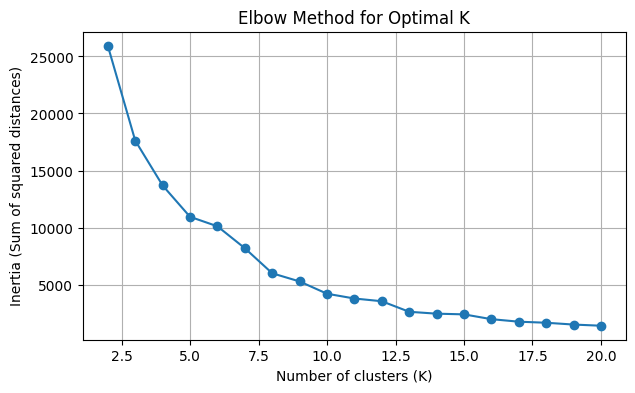

In [19]:
# Selecting optimal no. of clusters for new feature location clusters
k_values = range(2, 21)  

inertias = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.grid()
plt.show()


In [20]:
kmeans = KMeans(n_clusters=12, random_state=42)  #Elbow
data_cleaned_iqr['Location_Cluster'] = kmeans.fit_predict(coords_scaled)


In [39]:
selected_features = ['Area', 'Property Size (sq.m)', 'Latitude_Project', 'Longitude_Project',
                     'Transaction Size (sq.m)', 'Bedrooms',
                     'Property Sub Type', 'Project', 'Nearest Metro', 'Transaction Type', 'Transaction sub type', 'Nearest Mall', 'Property Type', 'Registration type', 'Location_Cluster', 'Parking']

# Model Training & Evaluation

In [111]:
X = data_cleaned_iqr
y = data_cleaned_iqr['Amount_winsorized']

X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.3, random_state=1)
categorical_cols_selected = X[selected_features].select_dtypes(include=['object']).columns

pipeline = Pipeline([
    ('encoder', ce.TargetEncoder(cols=categorical_cols_selected)),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [100, 200, 300], 
    'regressor__max_depth': [10, 20, 30], 
    'regressor__min_samples_split': [2, 5, 10],  
    'regressor__min_samples_leaf': [1, 2, 4],    
    'regressor__max_features': ['sqrt'], 
    'regressor__bootstrap': [True, False]      
}


grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=10, n_jobs=10)               
grid_search.fit(X_train, y_train)

print("\nBest hyperparameters found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nBest Model Evaluation on Test Set (Original Scale):")

mae_tuned = metrics.mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae_tuned)

mse_tuned = metrics.mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse_tuned)

rmse_tuned = np.sqrt(mse_tuned)
print("Root Mean Squared Error:", rmse_tuned)

r2_tuned = metrics.r2_score(y_test, y_pred)
print("R-squared:", r2_tuned)

# ---- Hyperparameter Tuning ----

Fitting 3 folds for each of 162 candidates, totalling 486 fits


KeyboardInterrupt: 

In [46]:
X = data_cleaned_iqr
y = data_cleaned_iqr['Amount_winsorized']

X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.3, random_state=1)

# Pipeline prevents data leakage during CV as the target encoder may receive the test data when applied

categorical_cols_selected = X[selected_features].select_dtypes(include=['object']).columns

pipeline = Pipeline([
    ('encoder', ce.TargetEncoder(cols=categorical_cols_selected)),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42, bootstrap = False, max_depth= 30, max_features= 'sqrt', min_samples_leaf= 1, 
                                        min_samples_split= 10, n_estimators= 500))
])

# Assigning sample weights to balance rarer but significant samples
y_train = y_train.to_numpy()
y_train_log = np.log(y_train + 1).reshape(-1, 1)

bandwidth = 0.2 * np.std(y_train_log)
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(y_train_log)

log_density = kde.score_samples(y_train_log)
density = np.exp(log_density)

alpha = 1.0
weights = 1 / (density ** alpha)
weights = weights / np.mean(weights)

pipeline.fit(X_train, y_train, regressor__sample_weight=weights)

rf_y_pred = pipeline.predict(X_test)

mae_tuned = metrics.mean_absolute_error(y_test, rf_y_pred)
print("Mean Absolute Error:", mae_tuned)

mse_tuned = metrics.mean_squared_error(y_test, rf_y_pred)
print("Mean Squared Error:", mse_tuned)

rmse_tuned = np.sqrt(mse_tuned)
print("Root Mean Squared Error:", rmse_tuned)

r2_tuned = metrics.r2_score(y_test, rf_y_pred)
print("R-squared:", r2_tuned)

# ----------BEST MODEL-----------

Mean Absolute Error: 138857.27528598544
Mean Squared Error: 57864268754.90012
Root Mean Squared Error: 240549.92985843943
R-squared: 0.9501211111887686


In [94]:
pipeline = Pipeline([
    ('encoder', ce.TargetEncoder(cols=categorical_cols_selected)),
    ('scaler', StandardScaler()),
    ('regressor', DummyRegressor())
])

pipeline.fit(X_train, y_train)

dummy_y_pred = pipeline.predict(X_test)

mae_tuned = metrics.mean_absolute_error(y_test, dummy_y_pred)
print("Mean Absolute Error:", mae_tuned)

mse_tuned = metrics.mean_squared_error(y_test, dummy_y_pred)
print("Mean Squared Error:", mse_tuned)

rmse_tuned = np.sqrt(mse_tuned)
print("Root Mean Squared Error:", rmse_tuned)

r2_tuned = metrics.r2_score(y_test, dummy_y_pred)
print("R-squared:", r2_tuned)

# ----Baseline Comparison----

Mean Absolute Error: 909133.168356485
Mean Squared Error: 1160110641021.5188
Root Mean Squared Error: 1077084.324006955
R-squared: -1.3150038096210181e-05


In [28]:
pipeline = Pipeline([
    ('encoder', ce.TargetEncoder(cols=categorical_cols_selected)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train, regressor__sample_weight=weights)

lr_y_pred = pipeline.predict(X_test)

mae_tuned = metrics.mean_absolute_error(y_test, lr_y_pred)
print("Mean Absolute Error:", mae_tuned)

mse_tuned = metrics.mean_squared_error(y_test, lr_y_pred)
print("Mean Squared Error:", mse_tuned)

rmse_tuned = np.sqrt(mse_tuned)
print("Root Mean Squared Error:", rmse_tuned)

r2_tuned = metrics.r2_score(y_test, lr_y_pred)
print("R-squared:", r2_tuned)

# ----Linear Regression Comparison----

Mean Absolute Error: 327786.0721363075
Mean Squared Error: 182196449275.49313
Root Mean Squared Error: 426844.7601593501
R-squared: 0.842947009773732


# Relevant Plots for Interpretation

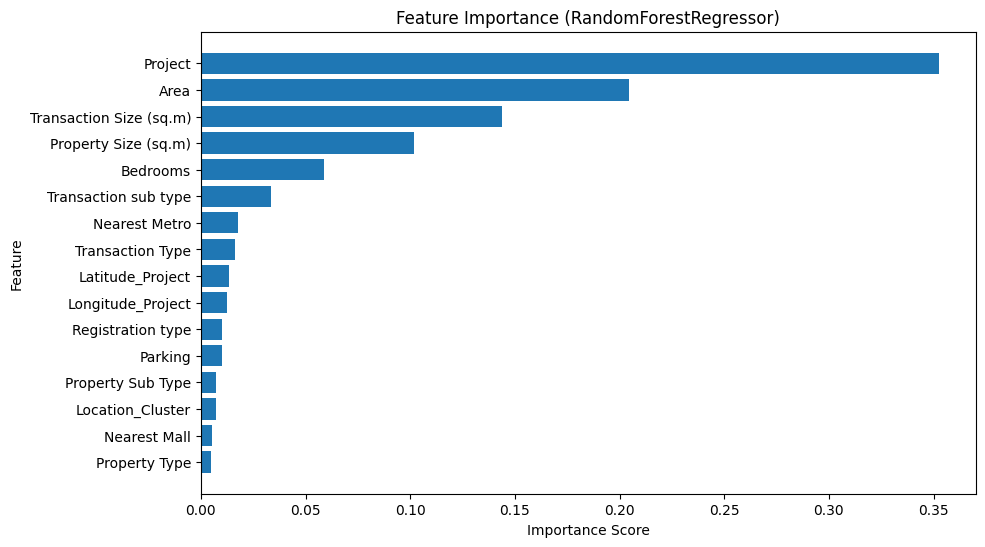

In [44]:
# Feature Importances of the model
encoder = ce.TargetEncoder(cols=categorical_cols_selected)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

model = RandomForestRegressor(random_state=42, bootstrap = False, max_depth= 30, max_features= 'sqrt', 
                              min_samples_leaf= 1, min_samples_split= 10, n_estimators= 500)
model.fit(X_train_encoded, y_train, sample_weight=weights)

importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'])
plt.title('Feature Importance (RandomForestRegressor)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()


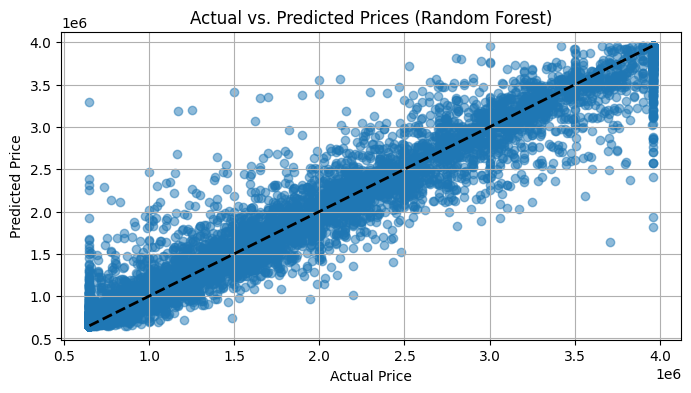

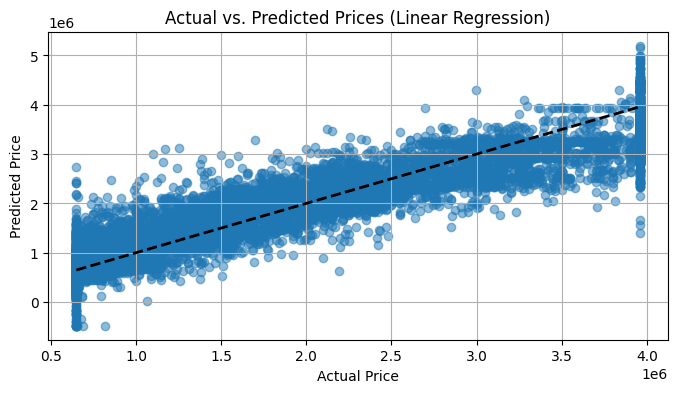

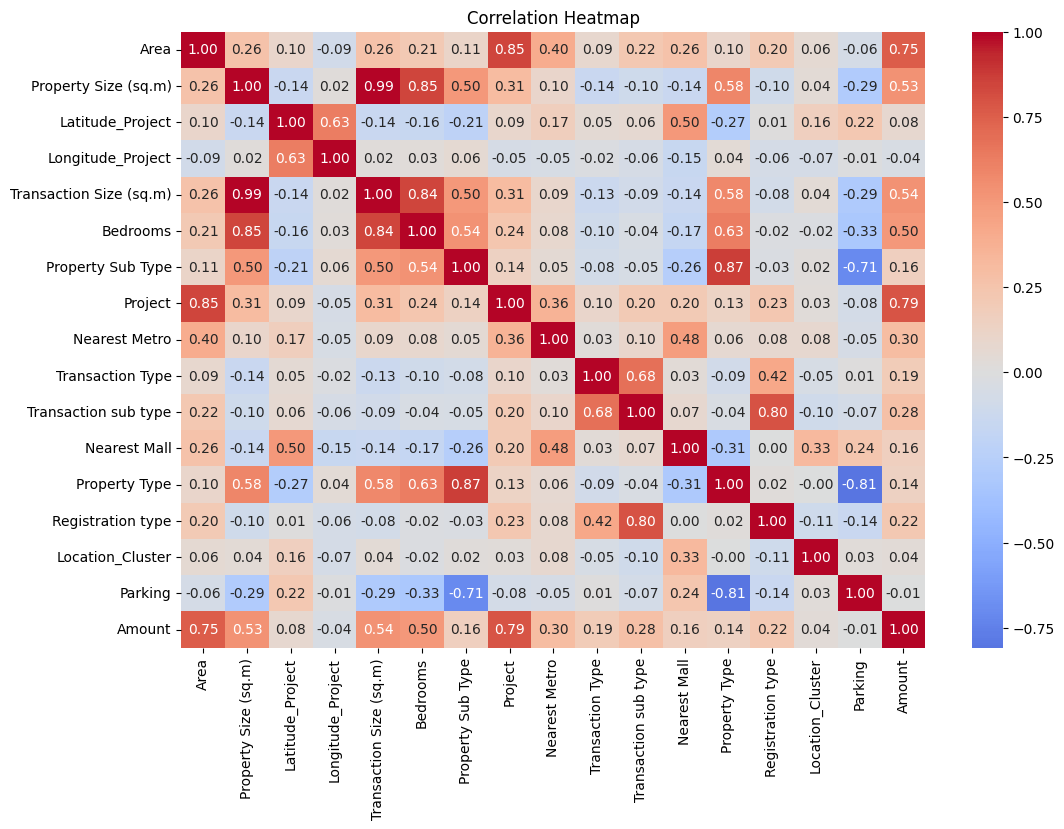

In [31]:
# Actual Vs Predicted Prices for Models
plt.figure(figsize=(8, 4))
plt.scatter(y_test, rf_y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Prices (Random Forest)')
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.scatter(y_test, lr_y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Prices (Linear Regression)')
plt.grid()
plt.show()

data_plot = X_train.copy()
data_plot['Amount'] = y_train  # or use 'Amount_winsorized' if preferred

data_plot = encoder.fit_transform(data_plot, y_train)

plt.figure(figsize=(12, 8))
sns.heatmap(data_plot.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

